# Validate

In [1]:
import os
import pickle
import json
from pathlib import Path
from typing import Sequence
from datetime import datetime, timedelta
from pprint import pprint

import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde
from numpy import typing as npt
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
import statsmodels.api as sm

### Load Data

In [2]:
list_percentage_leaderboard = [
	2435, 2445, 2454, 2464, 2467, 2478, 2549, 2762, 2860, 3507, 3526, 3928, 4493,
	2489, 3353, 3366, 3509,
	2551, 2667, 2749, 3064, 3080, 3288, 3338, 3517, 3641, 3774, 3800, 3926, 3929,
	3960, 4031, 4043, 4104, 4366, 4407, 4453, 4477, 4488, 4657, 4699, 4986, 5056,
	5144, 5174, 5229, 5261, 5357, 5390, 5497, 6322, 6927, 7115, 7162, 7634, 7878,
	8076, 8078, 8219, 8396, 8540, 9120, 9949, 10200, 10684, 13333, 14242, 14420,
	18045, 19018, 19991, 20270, 21669, 22962, 23249, 23652, 37077, 38128, 38760,
]

In [3]:
wd = os.getcwd()
wd_data = Path(os.path.join(wd, '__jsondata__'))
lst_data_json = list(wd_data.glob("*.json"))
len(lst_data_json)

78

In [4]:
contests_data = {
	'contest_id' : [],
	'data_json' : [],
	'data_post' : []
}
threshold_N_Delta = 2300

for path_json in lst_data_json:
	path_post = path_json.with_suffix(".pkl")
	contest_id = int(path_json.stem.split('_')[1])
	if contest_id not in list_percentage_leaderboard:
		continue
	with open(path_json, "r", encoding="utf-8") as f:
		data_json = json.load(f)
	if data_json['N_Delta'] > threshold_N_Delta:
		continue
	if not path_post.exists():
		continue
	with open(path_post, "rb") as f:
		data_post = pickle.load(f)
	contests_data['contest_id'].append(contest_id)
	contests_data['data_json'].append(data_json)
	contests_data['data_post'].append(data_post)

pprint(contests_data['contest_id'])

[2762,
 8396,
 20270,
 5357,
 3353,
 5229,
 9949,
 5497,
 2667,
 19018,
 22962,
 2489,
 3774,
 8076,
 14420,
 18045,
 3929,
 3641,
 7878,
 7634,
 4366,
 3509,
 2549,
 38128,
 2749,
 6927,
 2860,
 3288,
 3928,
 3338,
 3800,
 4453,
 5144,
 4493,
 5056,
 5390,
 2551,
 3507,
 4104,
 38760,
 4407,
 5261,
 6322,
 8078,
 23249,
 7162,
 3064,
 4488,
 3526,
 3926,
 8540,
 2478,
 19991,
 8219,
 21669,
 7115,
 13333,
 2454,
 3960,
 37077,
 3366,
 5174,
 10200,
 9120,
 4657,
 2445,
 3080,
 23652,
 4986,
 14242,
 4699,
 2464,
 10684,
 4031,
 4477]


In [5]:
list(contests_data['data_json'][0].keys())

['start_time',
 'theta',
 'percentage',
 'max_daily_submit',
 'ratio',
 'N_Delta',
 'Delta2f',
 'Ni',
 'Nj',
 'hat_t_i',
 'hat_t_j',
 'hat_y',
 'real_y']

In [6]:
list(contests_data['data_post'][0].keys())

['mu_0',
 'c_i',
 'c_j',
 'sigma',
 'lambda',
 'r',
 'm_i',
 'm_j',
 'tilde_y',
 'intensity_i',
 'intensity_i_at_events',
 'intensity_j',
 'intensity_j_at_events',
 'effort_gap',
 'hat_y_mean',
 'hat_y_cov']

### Display Data

In [7]:
def plot_ts_events(
		time_grids: Sequence[datetime],
		ts: dict[str, Sequence | npt.NDArray],
		events: dict[str, Sequence | npt.NDArray],
		ts_colors,
		ts_linestyles,
		*,
		ylim=None,
		figsize=(10, 5),
		height_ratios=[3, 1],
):
	fig, (ax_main, ax_events) = plt.subplots(
		nrows=2, ncols=1, figsize=figsize, height_ratios=height_ratios,
	)
	if ylim is not None:
		ax_main.set_ylim(ylim[0], ylim[1])
	# plot time series
	idx_line = 0
	for ts_key, ts_val in ts.items():
		ax_main.plot(
			time_grids, ts_val, label=ts_key,
			color=ts_colors[idx_line],
			linestyle=ts_linestyles[idx_line],
		)
		idx_line += 1
	ax_main.legend(frameon=False)
	ax_main.xaxis.set_major_locator(MaxNLocator(nbins=8))
	xrange = ax_main.get_xlim()
	# plot events
	event_height = 0.2
	ytick = 0
	yticks = []
	yticklabels = []
	for event_key, event_val in events.items():
		yticks.append(ytick)
		yticklabels.append(event_key)
		ax_events.hlines(y=ytick, xmin=xrange[0], xmax=xrange[1], color='black')
		ax_events.vlines(x=event_val, ymin=ytick - event_height, ymax=ytick + event_height, color='black')
		ytick -= 2.5 * event_height
	ax_events.set_xlim(xrange)
	ax_events.get_xaxis().set_visible(False)
	ax_events.set_yticks(yticks)
	ax_events.set_yticklabels(yticklabels)
	return fig, ax_main, ax_events

def plot_contest_data(contest_id: int):
	contest_idx = contests_data['contest_id'].index(contest_id)
	contest_data_json = contests_data['data_json'][contest_idx]
	contest_data_post = contests_data['data_post'][contest_idx]
	start_time = datetime.fromtimestamp(contest_data_json['start_time'])
	N_Delta = contest_data_json['N_Delta']
	time_grids = [start_time + i * timedelta(hours=1) for i in range(N_Delta)]
	arr_hat_y = contest_data_json['hat_y']
	arr_real_y = contest_data_json['real_y']
	arr_tilde_y = contest_data_post['tilde_y'].mean(axis=0)
	hat_t_i = [start_time + timedelta(hours=t) for t in contest_data_json['hat_t_i']]
	hat_t_j = [start_time + timedelta(hours=t) for t in contest_data_json['hat_t_j']]
	#print(len(time_grids), len(arr_tilde_y))
	fig, ax_main, ax_events = plot_ts_events(
		time_grids=time_grids,
		ts={
			r'real output gap ($y_t$)': arr_real_y,
			r'observed output gap ($\hat{y}_t$)': arr_hat_y,
			r'perceived output gap ($\tilde{y}_t$)': arr_tilde_y[:-1],
		},
		events={
			r'player $i$': hat_t_i,
			r'player $j$': hat_t_j,
		},
		ts_colors = ['blue', 'black', 'black'],
		ts_linestyles=['solid', 'solid', 'dashed']
	)
	return fig, ax_main, ax_events

def plot_post_efforts(contest_id: int):
	contest_idx = contests_data['contest_id'].index(contest_id)
	contest_data_json = contests_data['data_json'][contest_idx]
	contest_data_post = contests_data['data_post'][contest_idx]
	start_time = datetime.fromtimestamp(contest_data_json['start_time'])
	N_Delta = contest_data_json['N_Delta']
	time_grids = [start_time + i * timedelta(hours=1) for i in range(N_Delta)]
	i_effort_dynamic = contest_data_post['m_i'].mean(axis=0)
	j_effort_dynamic = contest_data_post['m_j'].mean(axis=0)
	plt.figure(figsize=(10, 3))
	plt.plot(np.array(time_grids), i_effort_dynamic, label='player i')
	plt.plot(np.array(time_grids), j_effort_dynamic, label='player j')
	plt.legend()
	plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=8))
	plt.show()

In [8]:
def calculate_lambda_mle(arr_hat_y, arr_real_y, Delta2f):
	"""
	"""
	n = len(arr_hat_y)
	mse = sum([(hat_y - y)**2 for hat_y, y in zip(arr_hat_y, arr_real_y)])
	return n / mse / Delta2f

def estimate_effort_kde(contest_id: int, bw: float = 0.5):
	"""Using kernel density estimation to estimate submisison intensity

	Return: intensity per hour
	"""
	contest_idx = contests_data['contest_id'].index(contest_id)
	contest_data_json = contests_data['data_json'][contest_idx]

	N_Delta = contest_data_json['N_Delta']
	time_grids_f = [i for i in range(N_Delta)]  # float
	hat_t_i_f = np.array(contest_data_json['hat_t_i'])
	hat_t_j_f = np.array(contest_data_json['hat_t_j'])

	kde_i = gaussian_kde(hat_t_i_f, bw_method=bw)
	kde_j = gaussian_kde(hat_t_j_f, bw_method=bw)
	density_i = kde_i(time_grids_f)
	density_j = kde_j(time_grids_f)
	intensity_i = density_i * len(hat_t_i_f)
	intensity_j = density_j * len(hat_t_j_f)

	start_time = datetime.fromtimestamp(contest_data_json['start_time'])
	time_grids = [start_time + timedelta(hours=i) for i in time_grids_f]
	hat_t_i = [start_time + timedelta(hours=t) for t in hat_t_i_f]
	hat_t_j = [start_time + timedelta(hours=t) for t in hat_t_j_f]
	return time_grids, hat_t_i, intensity_i, hat_t_j, intensity_j

def calculate_sigma_mle(contest_id: int) -> float:
	contest_idx = contests_data['contest_id'].index(contest_id)
	contest_data_json = contests_data['data_json'][contest_idx]
	contest_data_post = contests_data['data_post'][contest_idx]

	# json data
	N_Delta = contest_data_json['N_Delta']
	time_grids_f = [i for i in range(N_Delta)]  # float
	start_time = datetime.fromtimestamp(contest_data_json['start_time'])
	time_grids = time_grids = [start_time + timedelta(hours=i) for i in time_grids_f]
	arr_real_y = contest_data_json['real_y']
	Delta2f = contest_data_json['Delta2f']
	hat_t_i_f = np.array(contest_data_json['hat_t_i'])
	hat_t_j_f = np.array(contest_data_json['hat_t_j'])
	hat_t_i = [start_time + timedelta(hours=t) for t in hat_t_i_f]
	hat_t_j = [start_time + timedelta(hours=t) for t in hat_t_j_f]

	# posteriors
	effort_gap = contest_data_post['effort_gap'].mean(axis=0)

	# departion
	N = n_i = n_j = 0
	arr_tk = []
	arr_y_tk = []
	arr_sum_effort_gap = []
	sum_effort_gap = 0
	for t, y, effort_gap_s in zip(time_grids, arr_real_y, effort_gap):
		sum_effort_gap += effort_gap_s
		if n_i < len(hat_t_i) and t - timedelta(hours=1) < hat_t_i[n_i] < t:
			if len(arr_tk) > 0 and hat_t_i[n_i] <= arr_tk[-1]:
				n_i += 1
				continue
			arr_tk.append(hat_t_i[n_i])
			arr_y_tk.append(y)
			arr_sum_effort_gap.append(sum_effort_gap * Delta2f)
			sum_effort_gap = 0
			n_i += 1
			N += 1
		if n_j < len(hat_t_j) and t - timedelta(hours=1) < hat_t_j[n_j] < t:
			if len(arr_tk) > 0 and hat_t_j[n_j] <= arr_tk[-1]:
				n_j += 1
				continue
			arr_tk.append(hat_t_j[n_j])
			arr_y_tk.append(y)
			arr_sum_effort_gap.append(sum_effort_gap * Delta2f)
			sum_effort_gap = 0
			n_j += 1
			N += 1
	arr_sum_effort_gap = arr_sum_effort_gap[1:]  # drop the first

	# MLE
	arr_delta_tk = [(arr_tk[ii + 1] - arr_tk[ii]).total_seconds() / 3600 * Delta2f for ii in range(N - 1)]
	arr_delta_y_tk = [arr_y_tk[ii + 1] - arr_y_tk[ii] for ii in range(N - 1)]
	zip_3 = zip(arr_delta_tk, arr_delta_y_tk, arr_sum_effort_gap)
	mle_sigma_squared = np.mean([(Xk - Mk)**2 / Tk for Tk, Xk, Mk in zip_3])
	return float(mle_sigma_squared**0.5)

def display_estimation_results():
	data = []
	for id, json_data, posteriors in zip(
		contests_data['contest_id'], contests_data['data_json'], contests_data['data_post']
	):
		record = {
			'Id': id,
			'Ni': json_data['Ni'],
			'Nj': json_data['Nj'],
			'prize (k, USD)': json_data['theta'],
			'Percentage (%)': json_data['percentage'],
			'lambda_mle': calculate_lambda_mle(json_data['hat_y'], json_data['real_y'], json_data['Delta2f']),
			'lambda_post_mean': posteriors['lambda'].mean(),
			'sigma_mle': calculate_sigma_mle(id),
			'sigma_post_mean': posteriors['sigma'].mean(),
			'r_post_mean': posteriors['r'].mean(),
			'mu0_post_mean': posteriors['mu_0'].mean(),
		}
		data.append(record)
	return pd.DataFrame(data)

In [9]:
cross_contests = display_estimation_results()
cross_contests

,Id,Ni,Nj,"prize (k, USD)",Percentage (%),lambda_mle,lambda_post_mean,sigma_mle,sigma_post_mean,r_post_mean,mu0_post_mean
0,2762,12,21,1.00,35.0,20.922879,11.658846,1.244473,0.779192,13.004780,1.068398
1,8396,53,59,0.50,1.0,1158.201424,13.605550,2.451453,1.384845,16.516885,7.015920
2,20270,20,16,4.00,30.0,293.230428,18.848318,0.531336,0.815372,3.938130,-0.254665
3,5357,36,22,5.00,30.0,8980.087658,22.768188,0.354061,0.773677,3.022001,1.093249
4,3353,26,17,10.00,30.0,22001.195696,16.306769,1.409528,1.231797,2.066246,-0.248820
...,...,...,...,...,...,...,...,...,...,...,...
70,4699,13,22,5.00,30.0,223019.350989,18.733855,0.210781,0.764681,1.206507,0.111677
71,2464,11,12,0.95,20.0,99.555500,9.843920,3.740777,2.325192,14.217421,-0.473776
72,10684,16,58,4.00,57.0,32.621846,18.928571,1.341546,0.659158,4.785060,-7.057920
73,4031,6,61,5.00,30.0,125709.402114,19.131818,1.214034,0.830539,3.021199,0.604741


#### Example

In [10]:
contest_id = 2549
contest_idx = contests_data['contest_id'].index(contest_id)
contest_data_json = contests_data['data_json'][contest_idx]
contest_data_post = contests_data['data_post'][contest_idx]

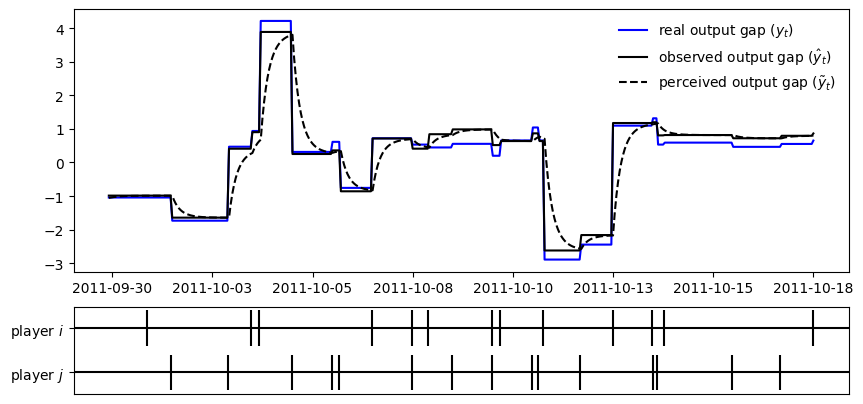

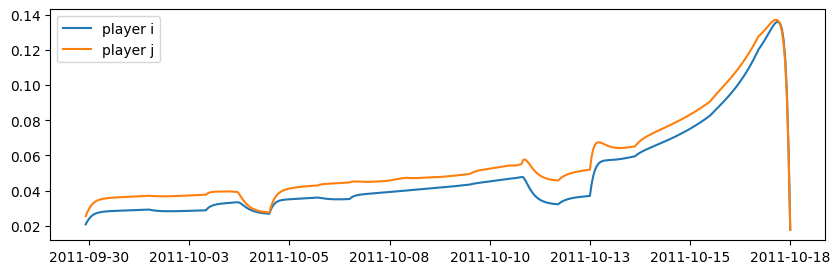

In [11]:
_ = plot_contest_data(contest_id)
plot_post_efforts(contest_id)

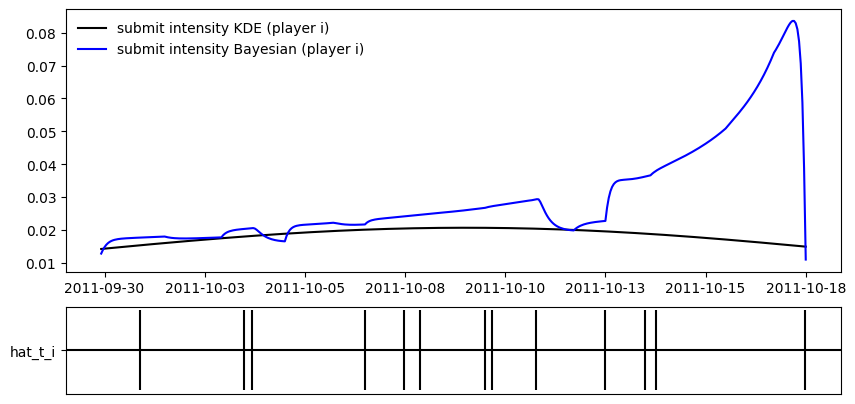

In [12]:
# Display submission intensity
contest_m_i = contest_data_post['m_i'].mean(axis=0)
contest_m_j = contest_data_post['m_j'].mean(axis=0)
contest_r = contest_data_post['r'].mean()
time_grids, hat_t_i, intensity_i, hat_t_j, intensity_j = estimate_effort_kde(contest_id, 2)
_ = plot_ts_events(time_grids, ts={
	'submit intensity KDE (player i)': intensity_i,
	'submit intensity Bayesian (player i)': contest_m_i * contest_r / 24,
	#'submit intensity (player j)': intensity_j,
	#'effort level (player j)': contest_m_j,
}, events={
	'hat_t_i': hat_t_i,
	#'hat_t_j': hat_t_j,
}, ts_colors = ['black', 'blue', 'black', 'blue'], ts_linestyles = ['solid', 'solid', 'dashed', 'dashed'],
)

#### Validate $\sigma$

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              sigma_mle   R-squared:                       0.317
Model:                            OLS   Adj. R-squared:                  0.308
Method:                 Least Squares   F-statistic:                     33.91
Date:                Mon, 26 May 2025   Prob (F-statistic):           1.44e-07
Time:                        08:13:32   Log-Likelihood:                -35.784
No. Observations:                  75   AIC:                             75.57
Df Residuals:                      73   BIC:                             80.20
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0539      0.116      0.464      0.644      -0.178       0.285
sigma_post_mean     0.8866      0.152      5.823      0.000       0.583       1.190
==============================================================================
Omnibus:                        1.280   Durbin-Watson:                   1.618
Prob(Omnibus):                  0.527   Jarque-Bera (JB):                0.774
Skew:                           0.225   Prob(JB):                        0.679
Kurtosis:                       3.214   Cond. No.                         5.08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

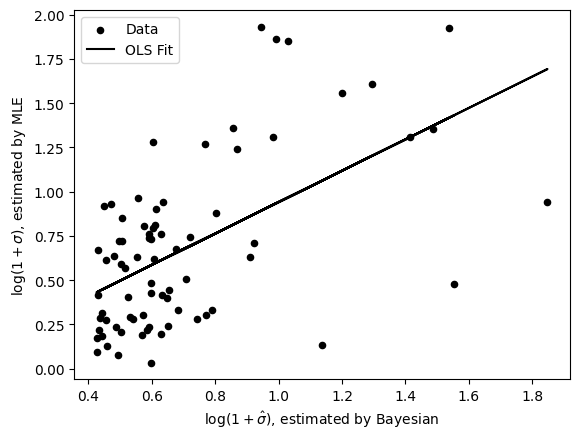

In [39]:
sigma_hat_bayes = np.log(1 + cross_contests['sigma_post_mean'])
sigma_hat_mle = np.log(1 + cross_contests['sigma_mle'])
X_sigma = sm.add_constant(sigma_hat_bayes)
model_sigma = sm.OLS(sigma_hat_mle, X_sigma).fit()
sigma_hat_fit = model_sigma.predict(X_sigma)
display(model_sigma.summary())

plt.scatter(sigma_hat_bayes, sigma_hat_mle, s=20, label="Data", color="black", )
plt.plot(sigma_hat_bayes, sigma_hat_fit, label="OLS Fit", color="black")
plt.xlabel(r"$\log(1+\hat\sigma)$, estimated by Bayesian")
plt.ylabel(r"$\log(1+\sigma)$, estimated by MLE")
plt.legend(loc='upper left')
plt.show()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              sigma_mle   R-squared:                       0.317
Model:                            OLS   Adj. R-squared:                  0.308
Method:                 Least Squares   F-statistic:                     33.91
Date:                Mon, 26 May 2025   Prob (F-statistic):           1.44e-07
Time:                        08:13:37   Log-Likelihood:                -35.784
No. Observations:                  75   AIC:                             75.57
Df Residuals:                      73   BIC:                             80.20
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0539      0.116      0.464      0.644      -0.178       0.285
sigma_post_mean     0.8866      0.152      5.823      0.000       0.583       1.190
==============================================================================
Omnibus:                        1.280   Durbin-Watson:                   1.618
Prob(Omnibus):                  0.527   Jarque-Bera (JB):                0.774
Skew:                           0.225   Prob(JB):                        0.679
Kurtosis:                       3.214   Cond. No.                         5.08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

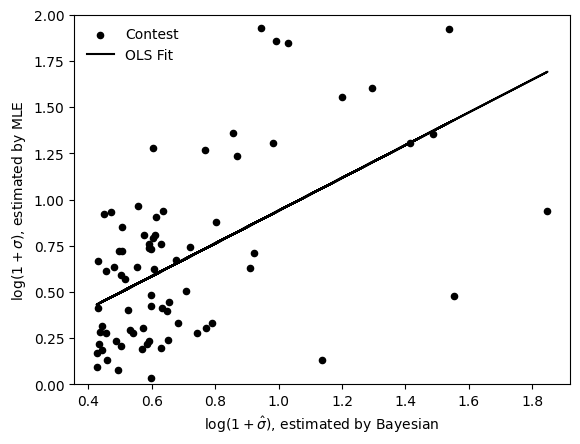

In [40]:
outlier_test_result = model_sigma.outlier_test(method='bonf', alpha=0.05)
#display(outlier_test_result)
non_outliers = outlier_test_result['bonf(p)'] > 0.05
outliers = outlier_test_result['bonf(p)'] <= 0.05
X_sigma_clean = X_sigma[non_outliers]
y_sigma_clean = sigma_hat_mle[non_outliers]
model_sigma_clean = sm.OLS(y_sigma_clean, X_sigma_clean).fit()
sigma_hat_fit_clean = model_sigma_clean.predict(X_sigma)
display(model_sigma_clean.summary())

if sum(outliers):
	plt.scatter(sigma_hat_bayes[outliers], sigma_hat_mle[outliers], s=20, label="Outliers", color="red", )
plt.scatter(sigma_hat_bayes[non_outliers], sigma_hat_mle[non_outliers], s=20, label="Contest", color="black", )
plt.plot(sigma_hat_bayes, sigma_hat_fit_clean, label="OLS Fit", color="black")
plt.ylim((0, 2))
plt.xlabel(r"$\log(1+\hat\sigma)$, estimated by Bayesian")
plt.ylabel(r"$\log(1+\sigma)$, estimated by MLE")
plt.legend(loc='upper left', frameon=False)
plt.savefig("../paper/validate_sigma.pdf", bbox_inches='tight')
plt.show()

#### Validate $\lambda$

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             lambda_mle   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     8.960
Date:                Mon, 26 May 2025   Prob (F-statistic):            0.00376
Time:                        08:13:44   Log-Likelihood:                -192.37
No. Observations:                  75   AIC:                             388.7
Df Residuals:                      73   BIC:                             393.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.7184      3.184     -0.226      0.822      -7.064       5.627
lambda_post_mean     3.2590      1.089      2.993      0.004       1.089       5.429
==============================================================================
Omnibus:                        0.376   Durbin-Watson:                   2.244
Prob(Omnibus):                  0.829   Jarque-Bera (JB):                0.070
Skew:                          -0.041   Prob(JB):                        0.966
Kurtosis:                       3.125   Cond. No.                         28.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

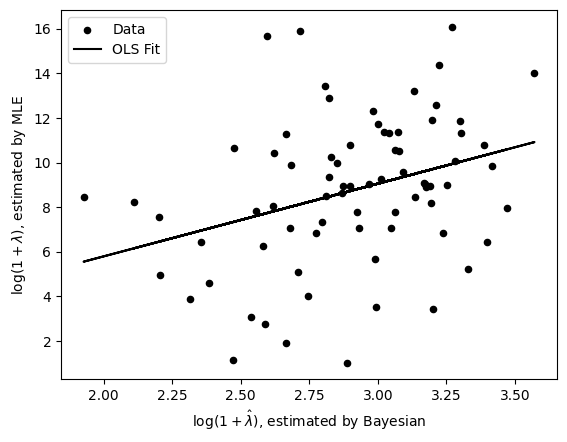

In [41]:
lamb_hat_bayes = np.log(1 + cross_contests['lambda_post_mean'])
lamb_hat_mle = np.log(1 + cross_contests['lambda_mle'])
X_lamb = sm.add_constant(lamb_hat_bayes)
model_lambda = sm.OLS(lamb_hat_mle, X_lamb).fit()
lamb_hat_fit = model_lambda.predict(X_lamb)
display(model_lambda.summary())

plt.scatter(lamb_hat_bayes, lamb_hat_mle, s=20, label="Data", color="black", )
plt.plot(lamb_hat_bayes, lamb_hat_fit, label="OLS Fit", color="black")
plt.xlabel(r"$\log(1+\hat\lambda)$, estimated by Bayesian")
plt.ylabel(r"$\log(1+\lambda)$, estimated by MLE")
plt.legend(loc='upper left')
plt.show()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             lambda_mle   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     8.960
Date:                Mon, 26 May 2025   Prob (F-statistic):            0.00376
Time:                        08:13:48   Log-Likelihood:                -192.37
No. Observations:                  75   AIC:                             388.7
Df Residuals:                      73   BIC:                             393.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.7184      3.184     -0.226      0.822      -7.064       5.627
lambda_post_mean     3.2590      1.089      2.993      0.004       1.089       5.429
==============================================================================
Omnibus:                        0.376   Durbin-Watson:                   2.244
Prob(Omnibus):                  0.829   Jarque-Bera (JB):                0.070
Skew:                          -0.041   Prob(JB):                        0.966
Kurtosis:                       3.125   Cond. No.                         28.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

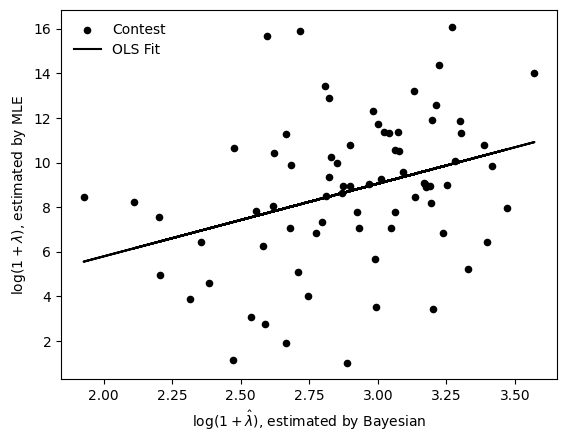

In [42]:
outlier_test_result = model_lambda.outlier_test(method='bonf', alpha=0.05)
# display(outlier_test_result)
non_outliers = outlier_test_result['bonf(p)'] > 0.05
outliers = outlier_test_result['bonf(p)'] <= 0.05
X_lamb_clean = X_lamb[non_outliers]
y_lamb_clean = lamb_hat_mle[non_outliers]
model_sigma_clean = sm.OLS(y_lamb_clean, X_lamb_clean).fit()
sigma_hat_fit_clean = model_sigma_clean.predict(X_lamb)
display(model_sigma_clean.summary())

if sum(outliers) > 0:
	plt.scatter(lamb_hat_bayes[outliers], lamb_hat_mle[outliers], s=20, label="Outliers", color="red")
plt.scatter(lamb_hat_bayes[non_outliers], lamb_hat_mle[non_outliers], s=20, label="Contest", color="black")
plt.plot(lamb_hat_bayes, sigma_hat_fit_clean, label="OLS Fit", color="black")

plt.xlabel(r"$\log(1+\hat\lambda)$, estimated by Bayesian")
plt.ylabel(r"$\log(1+\lambda)$, estimated by MLE")
plt.legend(loc='upper left', frameon=False)
plt.savefig("../paper/validate_lamb.pdf", bbox_inches='tight')
plt.show()